# Mission

Pair trading is a market-neutral trading strategy, enabling one to profit from almost any market condition, based on the historical cointegration of a pair of stocks. Shub Jain from Auquan [has written](https://medium.com/auquan/pairs-trading-data-science-7dbedafcfe5a) a great description of the principle, as well as a thorough explanation of creating a basic implementation. My task is to build on that foundation a more effective model. The modifications I shall make are the following:
1. Trading only discrete shares, because in reality shares are discrete, not continuous.
2. Trading long only, as I currently want to keep things simple by staying with stocks, not venturing into options.
3. Spreading the selling and buying over a few consecutive days.

In addition, I will optimize the model's parameters simply grid search and heatmaps.

In [3]:
import yfinance as yf 
import numpy as np
import itertools as it
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from statsmodels.tsa.stattools import coint
from datetime import datetime, timedelta
from math import floor, fmod

# Selecting a cointegrated pair

In order to prevent multiple comparison bias, it is best to not compare a huge amount of stocks, but to pick a few that one suspects of being cointegrated. The most natural set of cointegrated pairs are groups of companies in the same fields. As such, lets pick some IT companies from S&P 500.

In [184]:
instrument_ids = ['ADBE', 'AMD', 'AVGO', 'BSX', 'CDNS', 'CRM', 'HPQ', 'INTC', 'JNPR', 'MSFT', 'SPY']
start_date = '2010-06-07'
end_date = datetime.today().strftime('%Y-%m-%d')
data = yf.download(instrument_ids, start_date, end_date)['Adj Close']
data = data.interpolate()

[*********************100%***********************]  11 of 11 completed


It ought to be noted that I included the market benchmark (SPY) too. As explained in the article that inspired this project, the reason for this is that

  >"the market drives the movement of so many securities that often you might find two seemingly cointegrated securities; but in reality they are not cointegrated with each other but both conintegrated with the market. This is known as a confounding variable and it is important to check for market involvement in any relationship you find."
  
Plotting a heatmap of the p-values of the cointegration. The closer the p-value is to 0, the more certain we can be of the pair truly being cointegrated.  

In [3]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.02:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

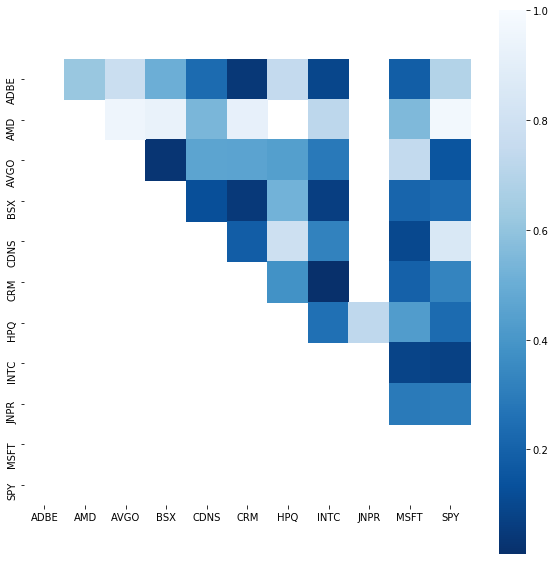

In [4]:
scores, pvalues, pairs = find_cointegrated_pairs(data)
m = [0,0.2,0.4,0.6,0.8,1]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pvalues, xticklabels=instrument_ids, 
                yticklabels=instrument_ids, cmap='Blues_r',
                mask = (pvalues >= 0.98))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_aspect("equal")

There are hence a few promising candidate pairs. Despite their not being the darkest pair, I shall choose MSFT and ADBE, as it is the only one of the candidates where the conitegration of each one with the market (SPY) is negligible. 

Now lets intuitively ascertain the cointegration by viewing the two series.

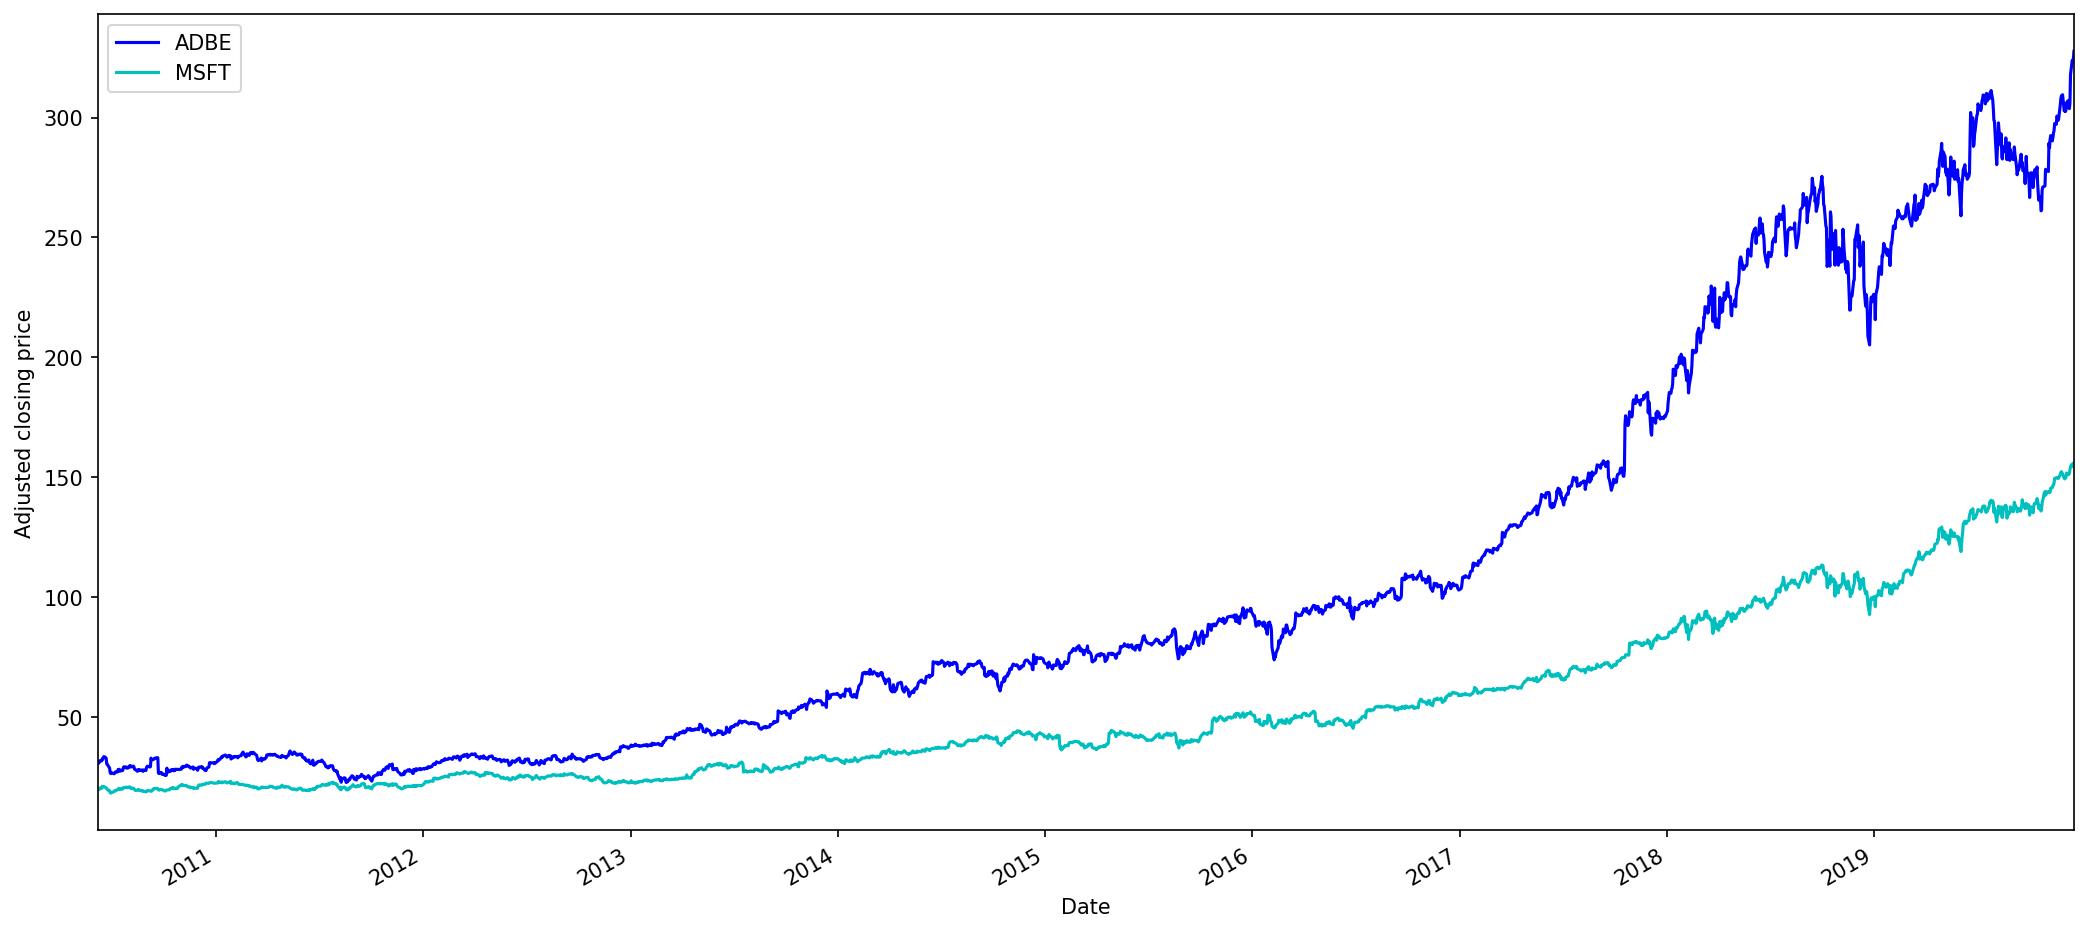

In [78]:
stock1 = 'ADBE'
stock2 = 'MSFT'

fig = plt.figure(figsize=(17,8), dpi=150)
ax = plt.gca()
S1, S2 = data[stock1], data[stock2]
S1.plot(color='b', ax=ax)
S2.plot(color='c', ax=ax)
ax.set_ylabel('Adjusted closing price')
ax.legend([stock1, stock2], loc='upper left');

Nice. Like a big brother and a little brother.

# Modeling

### General functions

In [171]:
def prepare_data(S1, S2, now_window, long_window):

    ratios = S1/S2
    
    ma1 = ratios.rolling(window=now_window, center=False).mean()
    ma2 = ratios.rolling(window=long_window, center=False).mean()
    std = ratios.rolling(window=long_window, center=False).std()
    
    zscore = (ma1 - ma2)/std
    
    # Remove the rows used to get the first the rolling means.
    S1, S2, zscore = S1[long_window:], S2[long_window:], zscore[long_window:]
    
    return S1, S2, zscore

In [141]:
def plot_model_result(S1, S2, V, S1_amounts, starting_price):  
    
    # Scaling the series so that the value of the result series is 1 at the initial purchase.
    # This enables to easily see what the relative gain is.
    V /= starting_price
    S1 /= starting_price 
    S2 /= starting_price
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,9), dpi=150)
    fig.subplots_adjust(hspace=0.5)
    
    S1.plot(color='b', ax=ax1, legend=stock1)
    S2.plot(color='c', ax=ax1, legend=stock2)
    V.plot(color='r', ax=ax1, legend='Total value')
    ax1.set_ylabel('Value relative to {}'.format(stock1))
    ax1.legend([stock1, stock2, 'Total value'])
    
    S1_amounts_series = pd.Series(S1_amounts, S1.index)
    S1_amounts_series.plot(color='black', ax=ax2, title='Amount of {}'.format(stock1))
    
    print('Achieved a {:.1f}-fold gain'.format(V[-1]))
    print('This is {:.1f} more than keeping to S1 would have yielded.'.format(V[-1] - S1[-1]))

### Model 1: basic pair trading

This model returns a series that is the total monetary value of at each point divided by the initial amount of S1. In other words, it is the time series of the values of the 'virtual' stock that can be compared to S1 in order to gauge the model's performance.

In [8]:
def model1(S1, S2, Z, initial_investment, threshold):
    
    # Start with no money and no positions
    total_value = []
    S1_amounts = []
    starting_price = 0 
    starting_amount = 0
    leftover_money = 0
    countS1 = 0
    countS2 = 0
    started = False
    #threshold = 1.7

    for i in range(len(Z)):

        # Buy initial position.
        if not started:
            if Z[i] > threshold:
                starting_price = S2[i]
                starting_amount = initial_investment // starting_price
                countS2 = starting_amount
                leftover_money = initial_investment % starting_price
                started = True
            elif Z[i] < -threshold:
                starting_price = S1[i]
                starting_amount = initial_investment // starting_price
                countS1 = starting_amount
                leftover_money = initial_investment % starting_price
                started = True

        # Sell S1 and buy S2.
        if (Z[i] > threshold) and (countS1 != 0):
            brutto_money = (countS1 * S1[i]) + leftover_money
            countS1 = 0
            countS2 = brutto_money // S2[i]
            leftover_money = brutto_money % S2[i]
        # Sell S2 and buy S1.
        elif (Z[i] < -threshold) and (countS2 != 0):
            brutto_money = (countS2 * S2[i]) + leftover_money
            countS2 = 0
            countS1 = brutto_money // S1[i]
            leftover_money = brutto_money % S1[i]

        S1_amounts.append(countS1)
        total_value.append(S1[i]*countS1 + S2[i]*countS2)
    
    # Dividing the series by the initial amount of stocks bought, in
    # order to find out the value of one 'virtual' stock.
    V = [x / starting_amount for x in total_value]
    # Making the virtuals into a Series with the same datetime indices
    # as S1 and S2 so it can be plotted on the same axis. 
    V = pd.Series(V, S1.index) 
        
    return V, S1_amounts, starting_price

Achieved a 17.3-fold gain
This is 5.5 more than keeping to S1 would have yielded.


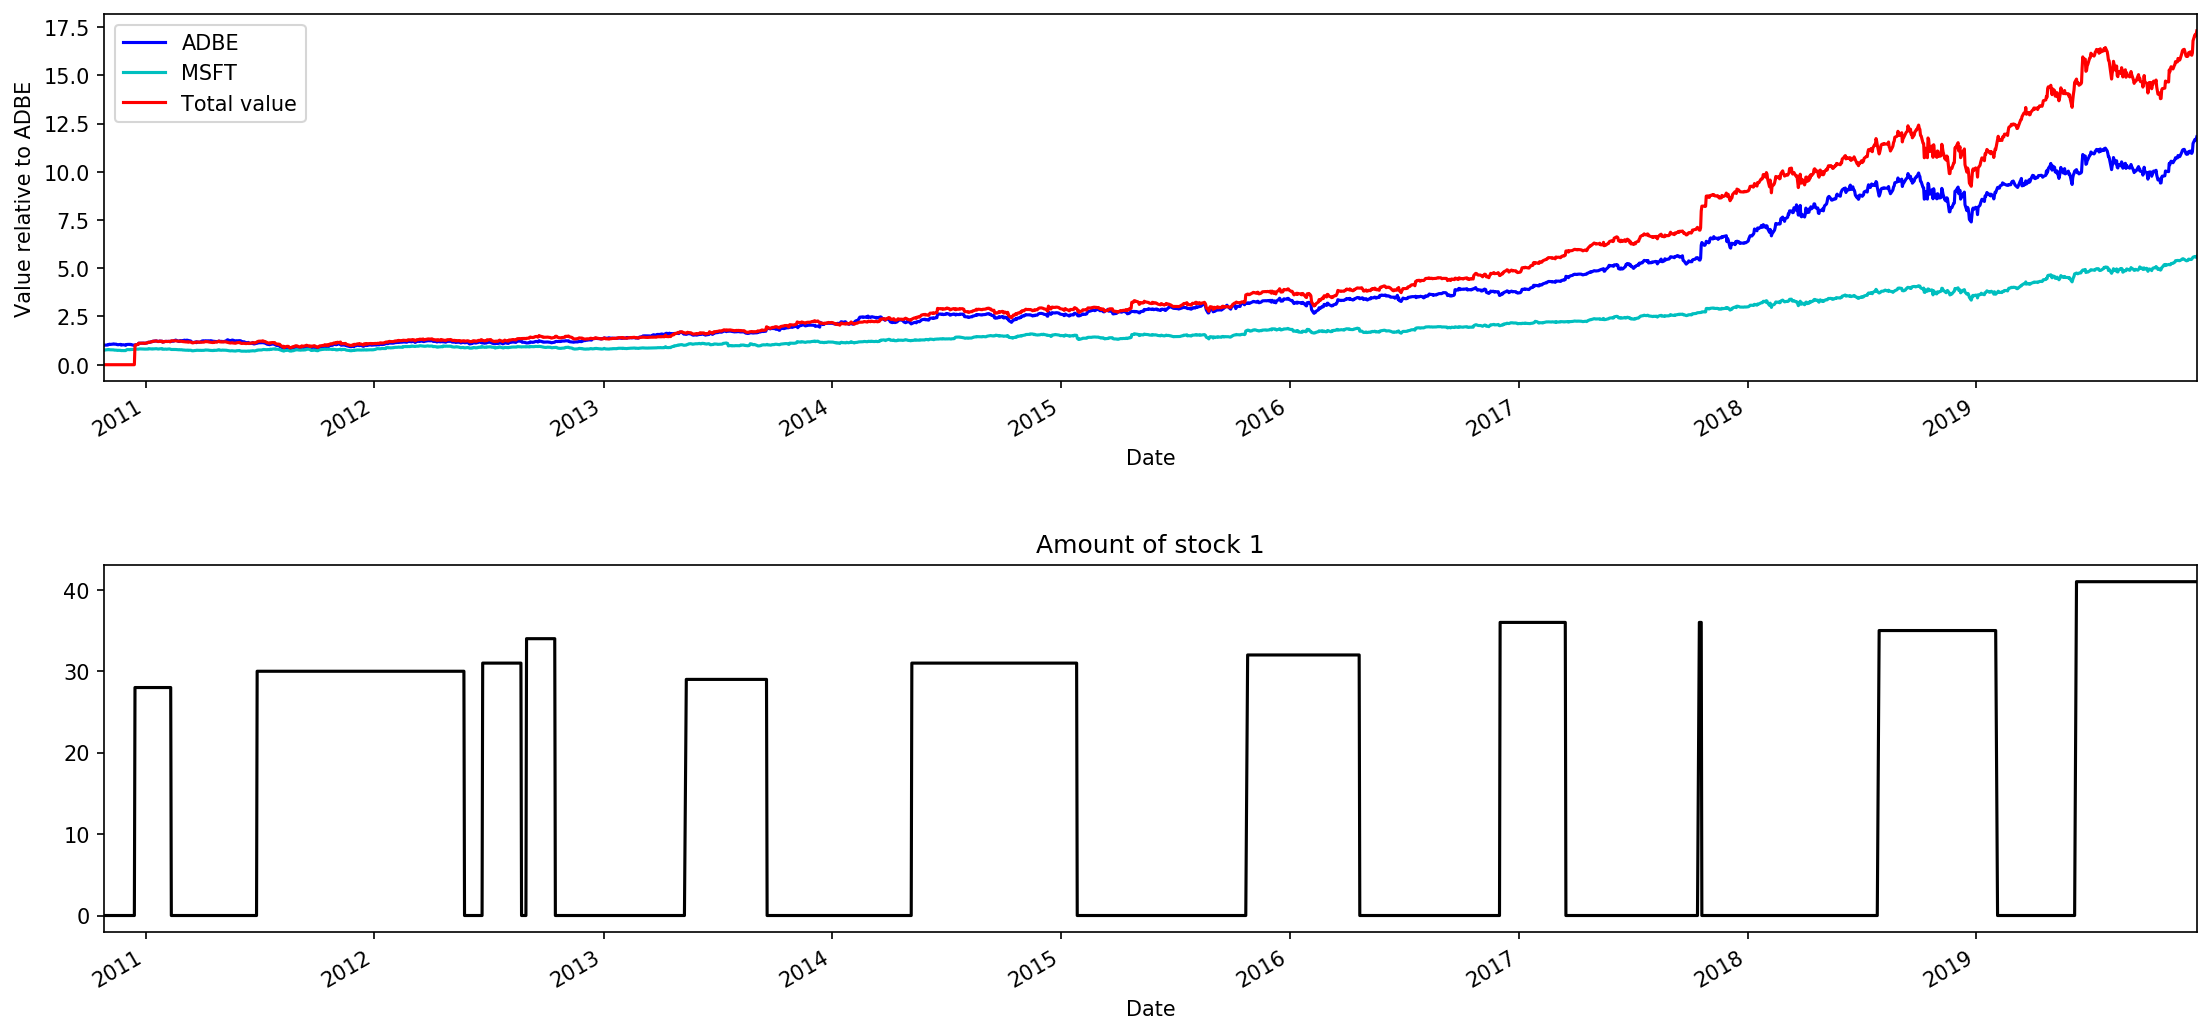

In [46]:
initial_investment = 800 # USD
now_window = 2
long_window = 100

S1, S2, Z = prepare_data(data, now_window, long_window)
V, S1_amounts, starting_price = model1(S1, S2, Z, initial_investment, threshold)
plot_model_result(V, S1_amounts, starting_price) 

This is what the result looks like for one set of parameters only. Other sets give higher or lower results, some far lower than just holding onto ADBE. 

### Model 2: transaction stretch-out

In this variation, when the transaction is triggered, the bying is spread between a few days. The selling is still conducted in a single day.

Note that having sold one position, we always buy the other on following day, unlike in Model 1 where the two transactions are conducted the same day.

In [ ]:
def model2(S1, S2, Z, initial_investment, day_spread, backstop, threshold):
    
    # Start with no money and no positions
    total_value = []
    S1_amounts = []
    starting_price = 0 
    starting_amount = 0
    leftover_money = 0
    countS1 = 0
    countS2 = 0
    started = False
    #threshold = 1.7

    # These are needed for spreading the buying and selling over several days.
    is_buying = False
    is_selling = False
    days_done = 0
    daily_money_portion = 0
    
    # Buy initial position. 
    starting_price = S1[0]
    starting_amount = initial_investment // starting_price
    countS1 = starting_amount
    leftover_money = initial_investment % starting_price
    
    
    for i in range(len(Z)):

        # Continuing the daily buying or selling only if there either is no backstop,
        # or the z-score is still above 1 or below -1.
        continue_buy_sell = True if ~backstop else (abs(Z[i]) > threshold)
        
        if (is_buying or is_selling) and continue_buy_sell:
            
            if is_selling:
                total_daily_portion = daily_money_portion + leftover_money
                countS2 += total_daily_portion // S2[i]
                leftover_money = total_daily_portion % S2[i]
            elif is_buying:
                total_daily_portion = daily_money_portion + leftover_money
                countS1 += total_daily_portion // S1[i]
                leftover_money = total_daily_portion % S1[i]
                
            if days_done == (day_spread - 1):
                days_done = 0
                is_selling = False
                is_buying = False
            else:
                days_done += 1

        else:
            # Start buying if the z-score is > 1
            if (Z[i] > threshold) and (countS1 != 0):
                #total_money = countS1 * S1[i]
                daily_money_portion = (countS1 * S1[i]) / day_spread
                countS1 = 0
                is_selling = True
            # Start buying if the z-score is < 1
            elif (Z[i] < -threshold) and (countS2 != 0):
                #total_money = countS2 * S2[i]
                daily_money_portion = (countS2 * S2[i]) / day_spread
                countS2 = 0
                is_buying = True

        S1_amounts.append(countS1)
        
        if (is_buying or is_selling):
            total_value.append(daily_money_portion * day_spread)
        else:
            total_value.append(S1[i]*countS1 + S2[i]*countS2)
    
    # Dividing the series by the initial amount of stocks bought, in
    # order to find out the value of one 'virtual' stock.
    V = [x / starting_amount for x in total_value]
    # Making the virtuals into a Series with the same datetime indices
    # as S1 and S2 so it can be plotted on the same axis. 
    V = pd.Series(V, S1.index)
        
    return V, S1_amounts, starting_price

Achieved a 18.2-fold gain
This is 6.5 more than keeping to S1 would have yielded.


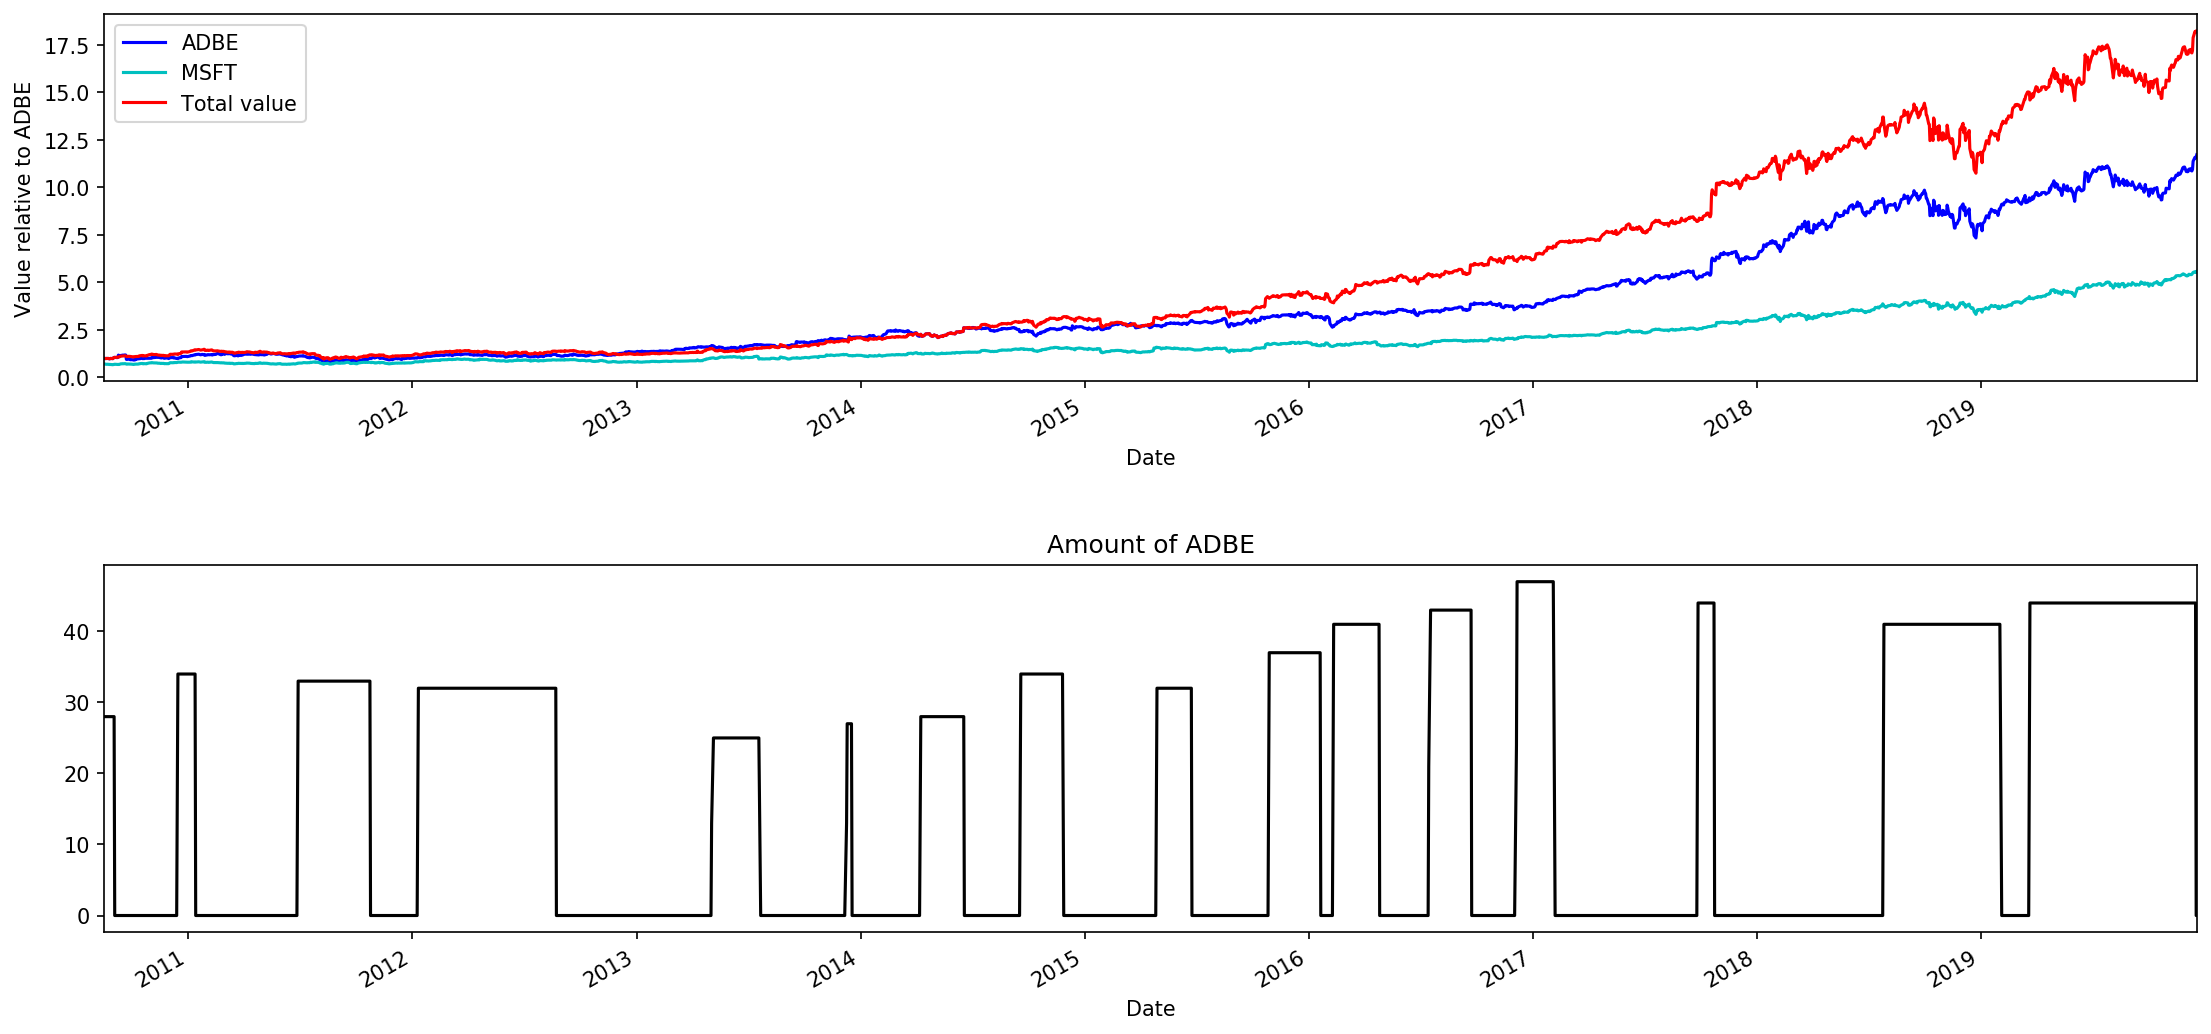

In [83]:
initial_investment = 800 # USD
now_window = 4
long_window = 50
day_spread = 2
backstop=False
threshold = 1.7

S1, S2, Z = prepare_data(data, now_window, long_window)
V, S1_amounts, starting_price = model2(S1, S2, Z, initial_investment, day_spread, backstop, threshold)
plot_model_result(V, S1_amounts, starting_price) 

Which of the two models is better? It is hard to tell by fiddling around with the parameters, as the space thereof is quite vast. So I will conduct a grid search instead.

# Optimization

### Windows

Finding the optimal length of the *now window* and the *long window*, by plotting a heatmap of them against the last ratio of the virtual value to the actual value of the upper stock; in other words, the gain in value using these models relative to simply holding on to the upper stock. In the case of Model 2 I will also find the best value for *day_spread*.

In [137]:
def model_result(S1, S2, wg, initial_investment, i, j, spread_days):
    S1, S2, Z = prepare_data(S1, S2, wg['now'][int(i)], wg['long'][int(j)])
    if spread_days > 0:
        V, S1_amounts, _ = model2(S1, S2, Z, initial_investment, spread_days, backstop=False)
    else:
        V, S1_amounts, _ = model1(S1, S2, Z, initial_investment)
    return V[-1]/S1[-1]

In [515]:
def windows_heatmap(stock1, stock2, spread_days, ax, backstop=False):

    global data
    
    initial_investment = 800 # USD

    window_grid = {
                    'now': np.arange(1, 9, 1),
                    'long': np.arange(10, 90, 1)
                  }
    
    now_length, long_length = len(window_grid['now']), len(window_grid['long'])
    ratio_matrix = np.zeros([now_length, long_length])

    for i,j in it.product(*[range(now_length), range(long_length)]):
        S1, S2, Z = prepare_data(data[stock1], data[stock2], window_grid['now'][int(i)], window_grid['long'][int(j)])
            
        if spread_days > 0:
            V, S1_amounts, _ = model2(S1, S2, Z, initial_investment, spread_days, backstop, threshold)
        else:
            V, S1_amounts, _ = model1(S1, S2, Z, initial_investment)

        ratio_matrix[i,j] = V[-1]/S1[-1]
        
 
    ax = sns.heatmap(ratio_matrix, 
                     cmap='seismic', 
                     xticklabels=window_grid['long'], 
                     yticklabels=window_grid['now'],
                     center=1,
                     vmin=0, vmax=3,
                     cbar=False,
                     ax=ax)
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_aspect("equal")
    
    if spread_days > 0:
        title = 'Using Model 2 with a spread of {} days.'.format(spread_days)
    else:
        title = 'Using Model 1.'
    ax.set_title(title)
    
    ax.set_ylabel('Long window', labelpad=10)
    ax.set_xlabel('Now window', labelpad=10)
    label_freq = 5
    for ind, label in enumerate(ax.get_xticklabels()):
        label.set_visible((ind % label_freq) == 0)
    
    plt.rcParams.update({'font.size': 13})

/Users/mikaelkoskela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 1.0, 'Gain compared to holding onto ADBE')

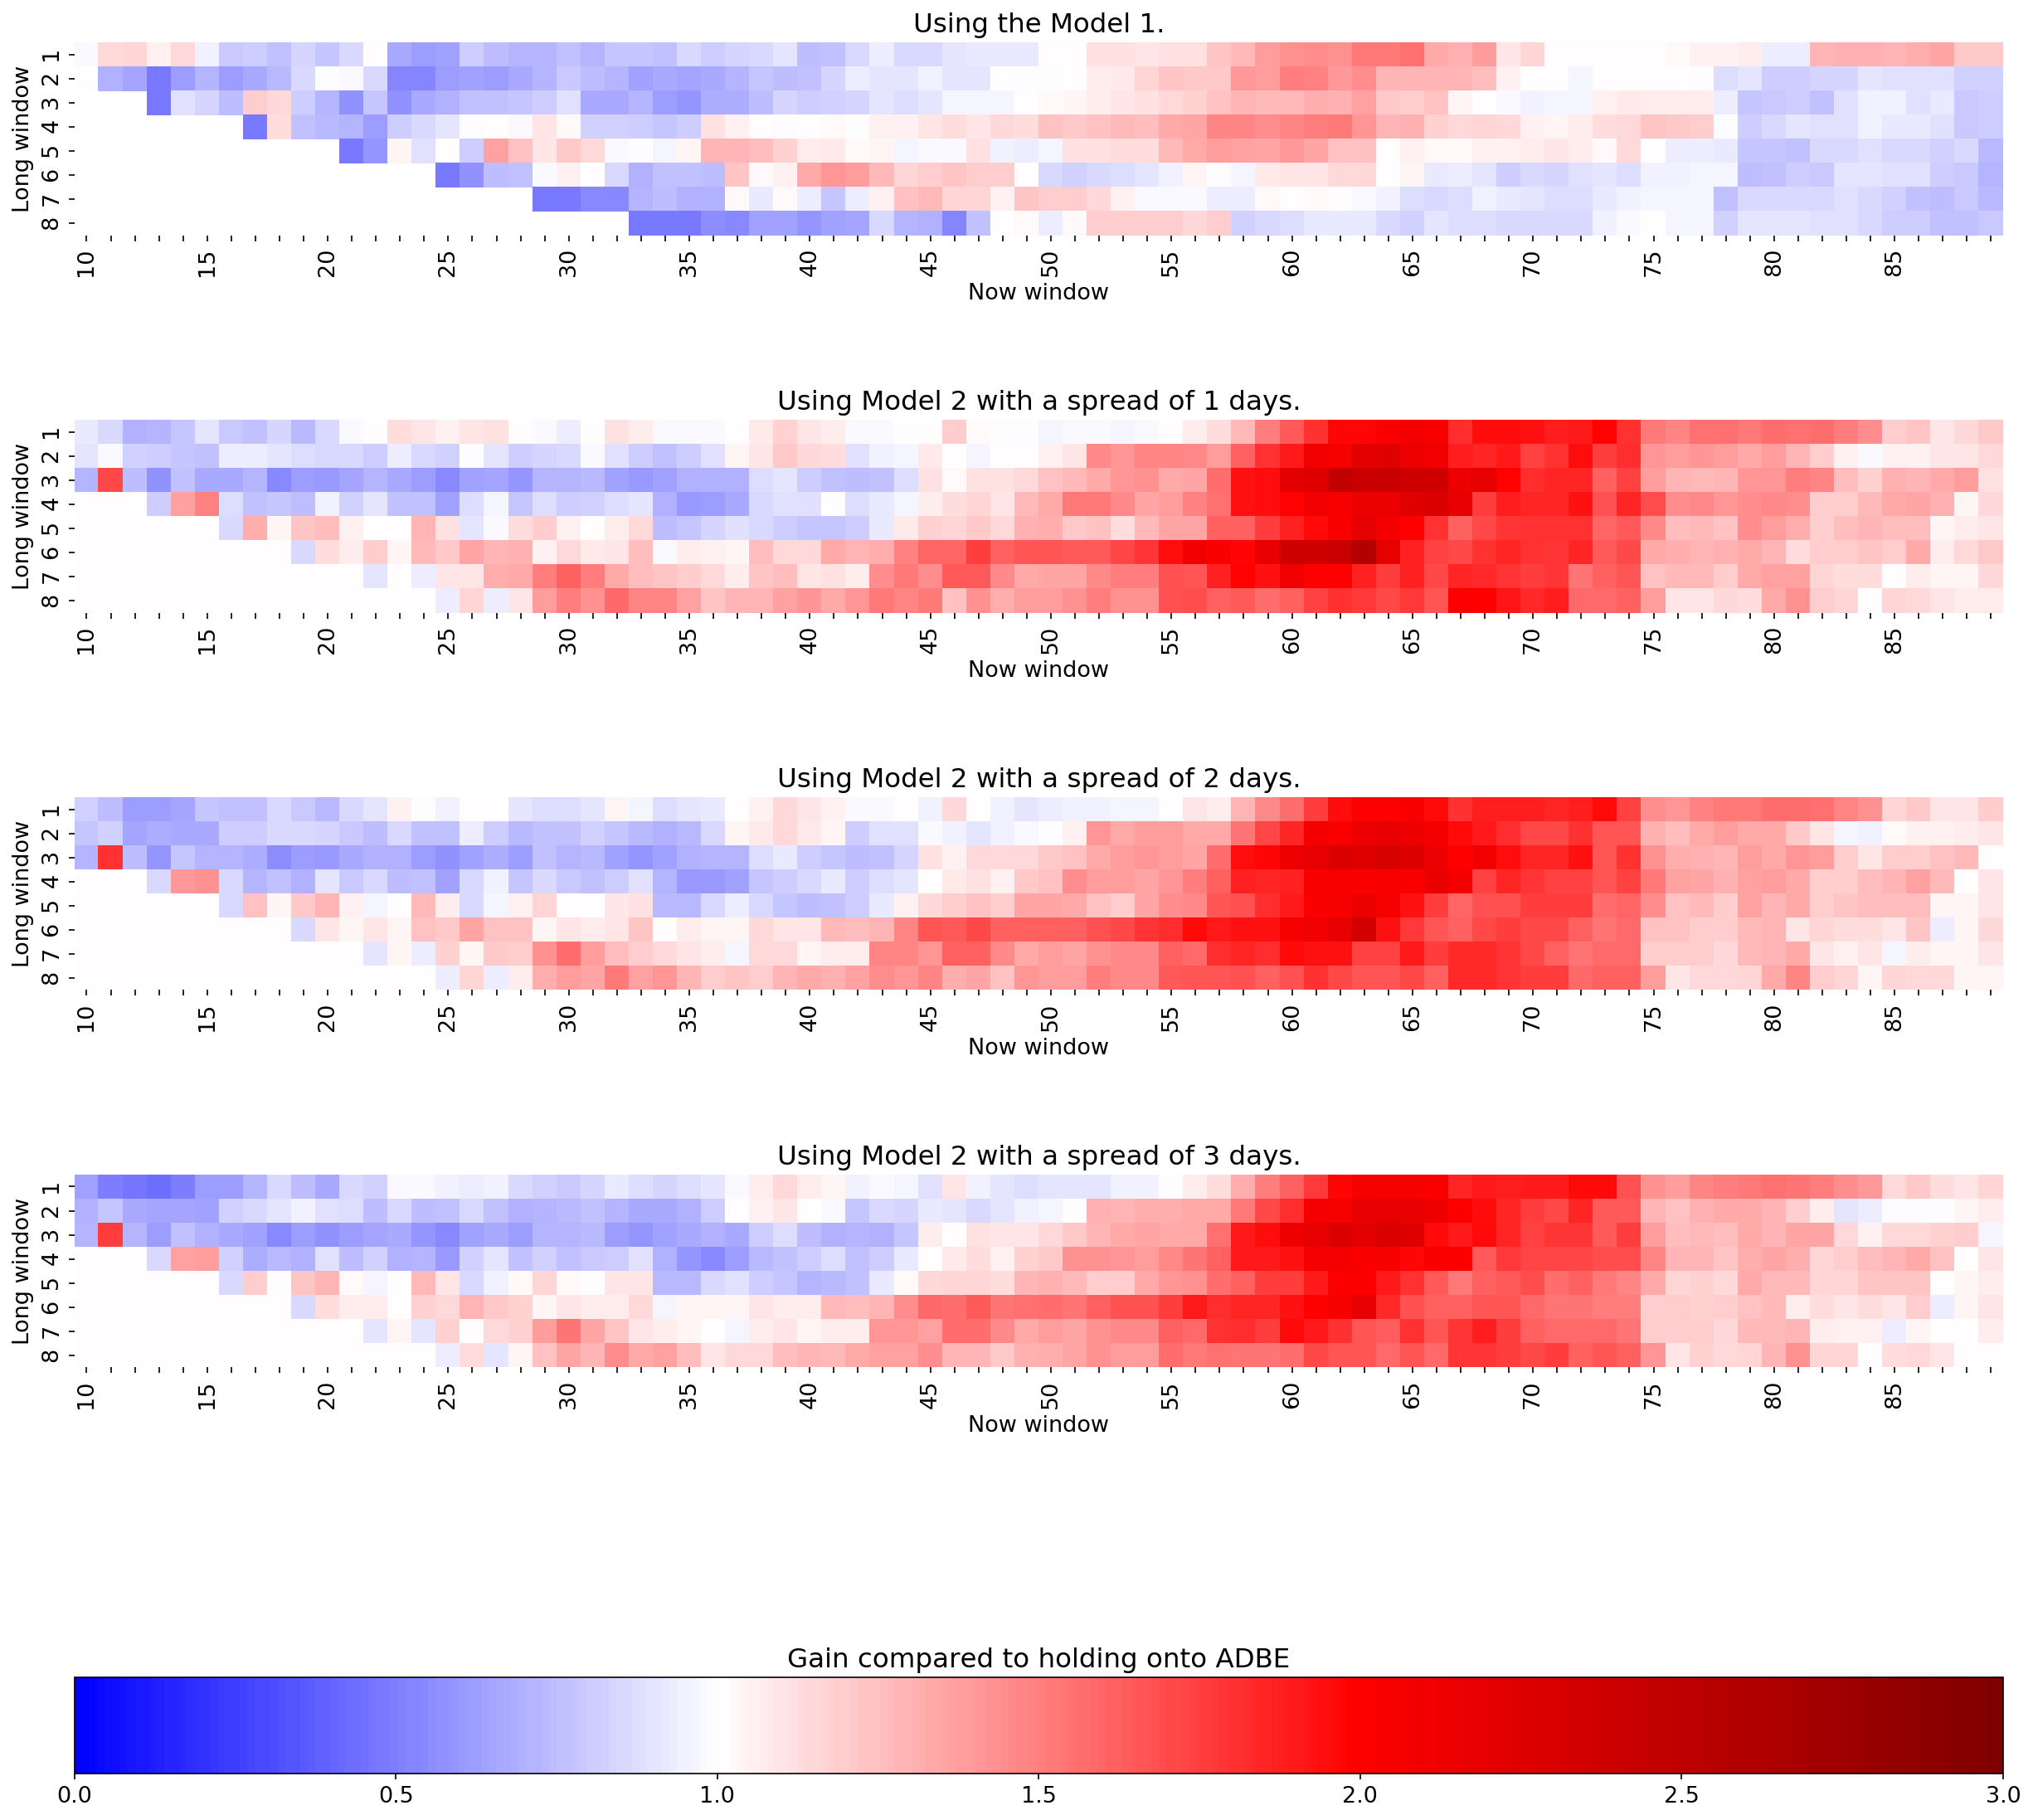

In [481]:
stock1 = 'ADBE'
stock2 = 'MSFT'

fig, axs = plt.subplots(4, 1, figsize=(20,22), dpi=150, sharex=True)

windows_heatmap(stock1, stock2, 0, axs[0])
windows_heatmap(stock1, stock2, 1, axs[1])
windows_heatmap(stock1, stock2, 2, axs[2])
windows_heatmap(stock1, stock2, 3, axs[3])

label = 'Gain compared to holding onto {}'.format(stock1)
mappable = axs[0].get_children()[0]
plt.colorbar(mappable, ax = [axs[0],axs[1],axs[2],axs[3]], orientation = 'horizontal').ax.set_title(label)

This model's superiority is visible not only as the greater darkness of the red, but also as the lower risk in the region with a long window, as it is red instead of blue. The difference between Model 1, and Model 2 with a day spread of 1, is that in the former, we buy the other position on the same day as we sold the other, while in the latter we buy it on the following day. It is remarkable how much the wait of one day affects the result). 

Increasing the windows seems to have a small negative effect on the gain. There is thus no reason to use any other day spread than 1.

Now we should try using the **backstop** in Model 2:

Text(0.5, 1.0, 'Gain compared to holding onto ADBE')

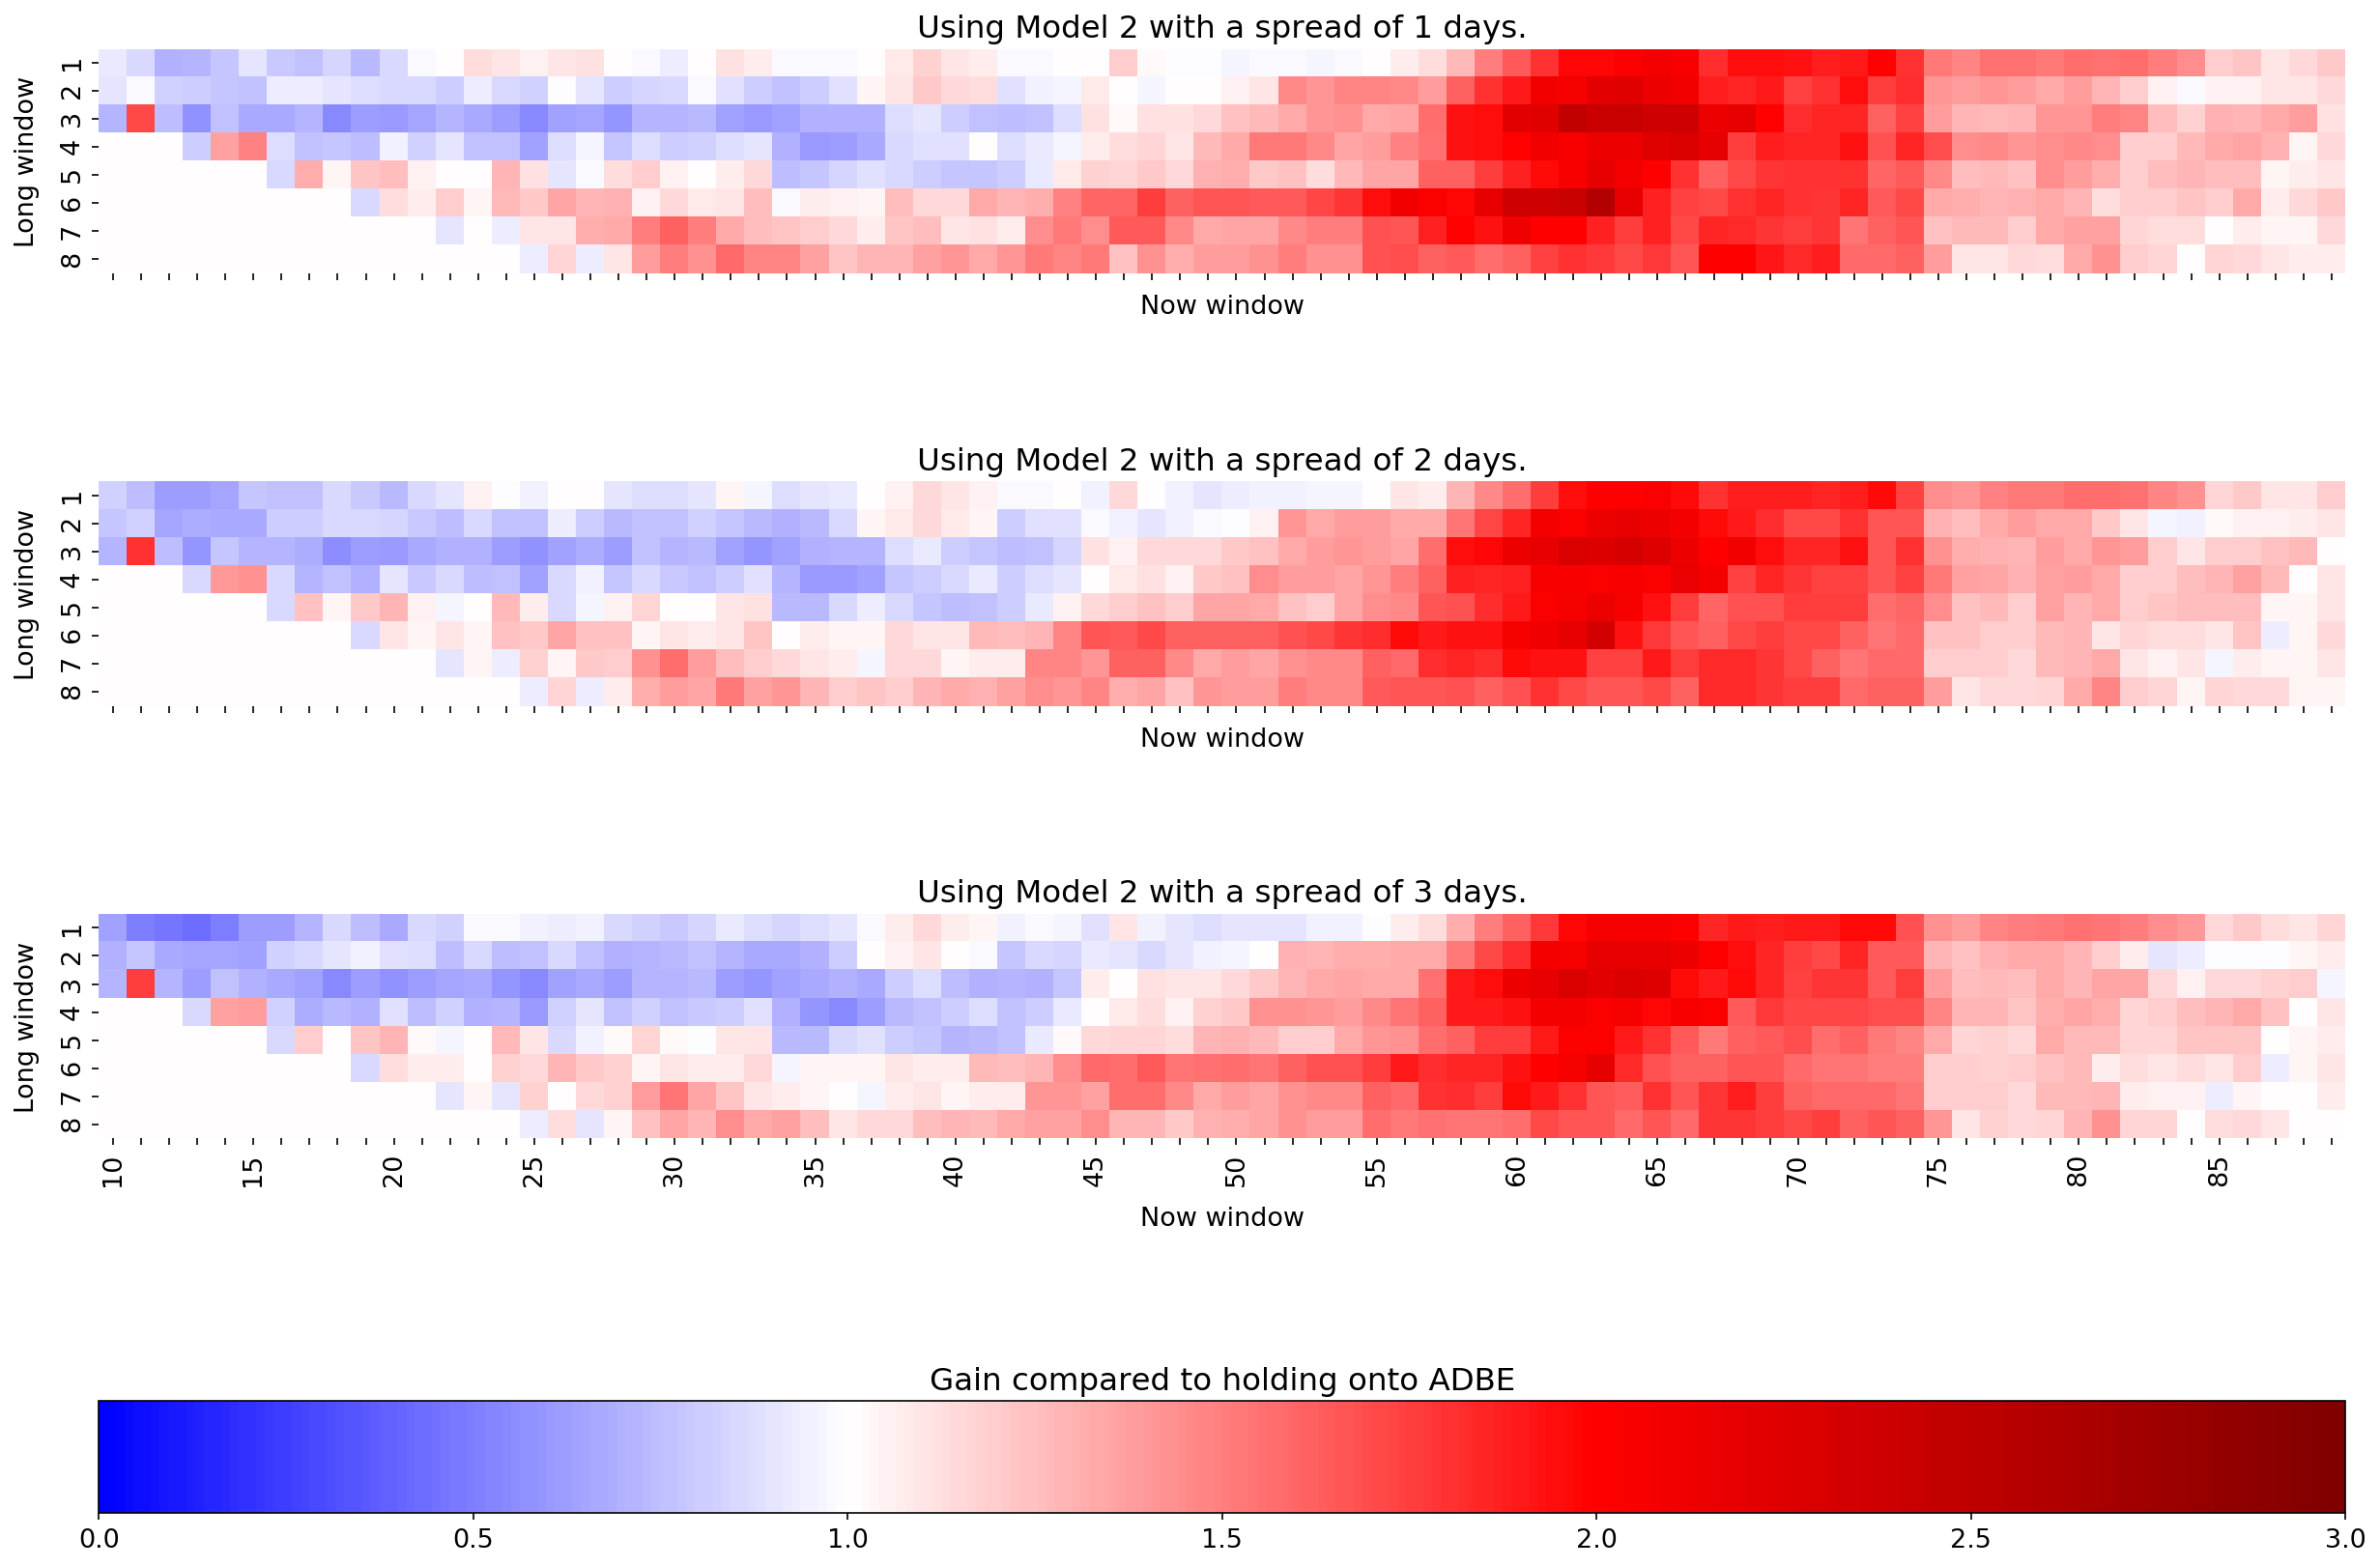

In [520]:
fig, axs = plt.subplots(3, 1, figsize=(20,16), dpi=150, sharex=True)

windows_heatmap(stock1, stock2, 1, axs[0])
windows_heatmap(stock1, stock2, 2, axs[1])
windows_heatmap(stock1, stock2, 3, axs[2])

label = 'Gain compared to holding onto {}'.format(stock1)
mappable = axs[0].get_children()[0]
plt.colorbar(mappable, ax = [axs[0],axs[1],axs[2]], orientation = 'horizontal').ax.set_title(label)

Comparing these to the above, we must admit that the backstop has negligible effect.

Lastly, it is worth checking out how the model performs with another pair. Choosing the pair with the lowest of the p-values, that is, highest cointegration: **AVGO** and **BSX**

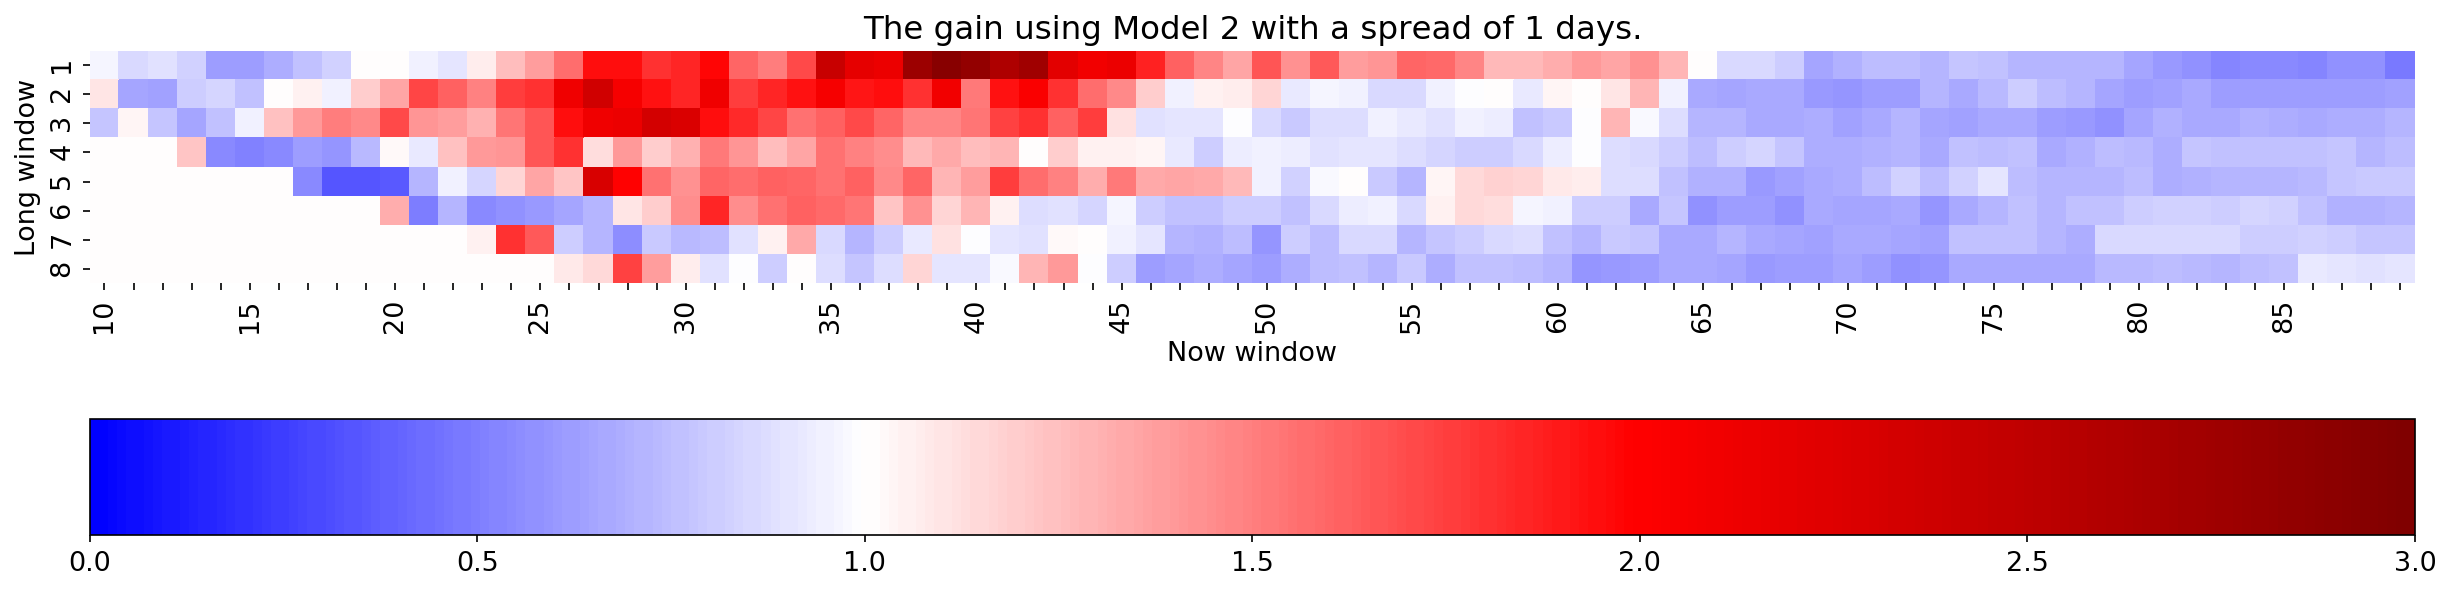

In [450]:
stock1 = 'AVGO'
stock2 = 'BSX'

fig = plt.figure(figsize=(20,8), dpi=150)
ax = plt.gca()
windows_heatmap(stock1, stock2, 1, ax)
plt.colorbar(ax.get_children()[0], ax = ax, orientation = 'horizontal')

The optimal point, (39, 1) yields a boost of as much as 3.41 (exceeding the heatmap's color range, which I calibrated for the original pair).

### Threshold

Next I will choose three of the points from the heatmap of Model 2 with a spread days of 1 and 3, and look at the behavior of the gain as the threshold is changed. (One of the points is the maximum.)

In [513]:
def threshold_plot(stock1, stock2, now_window, long_window, spread_days, backstop=False):

    global data
    
    values = []
    thresholds = np.arange(0.1, 3, 0.05)

    for t in thresholds:
        S1, S2, Z = prepare_data(data[stock1], data[stock2], now_window, long_window)
        V, S1_amounts, _ = model2(S1, S2, Z, initial_investment, spread_days, backstop, t)
        values.append(V[-1]/S1[-1])

    plt.plot(thresholds, values, label='{}, {}'.format(now_window, long_window))
    plt.legend(loc="upper left")

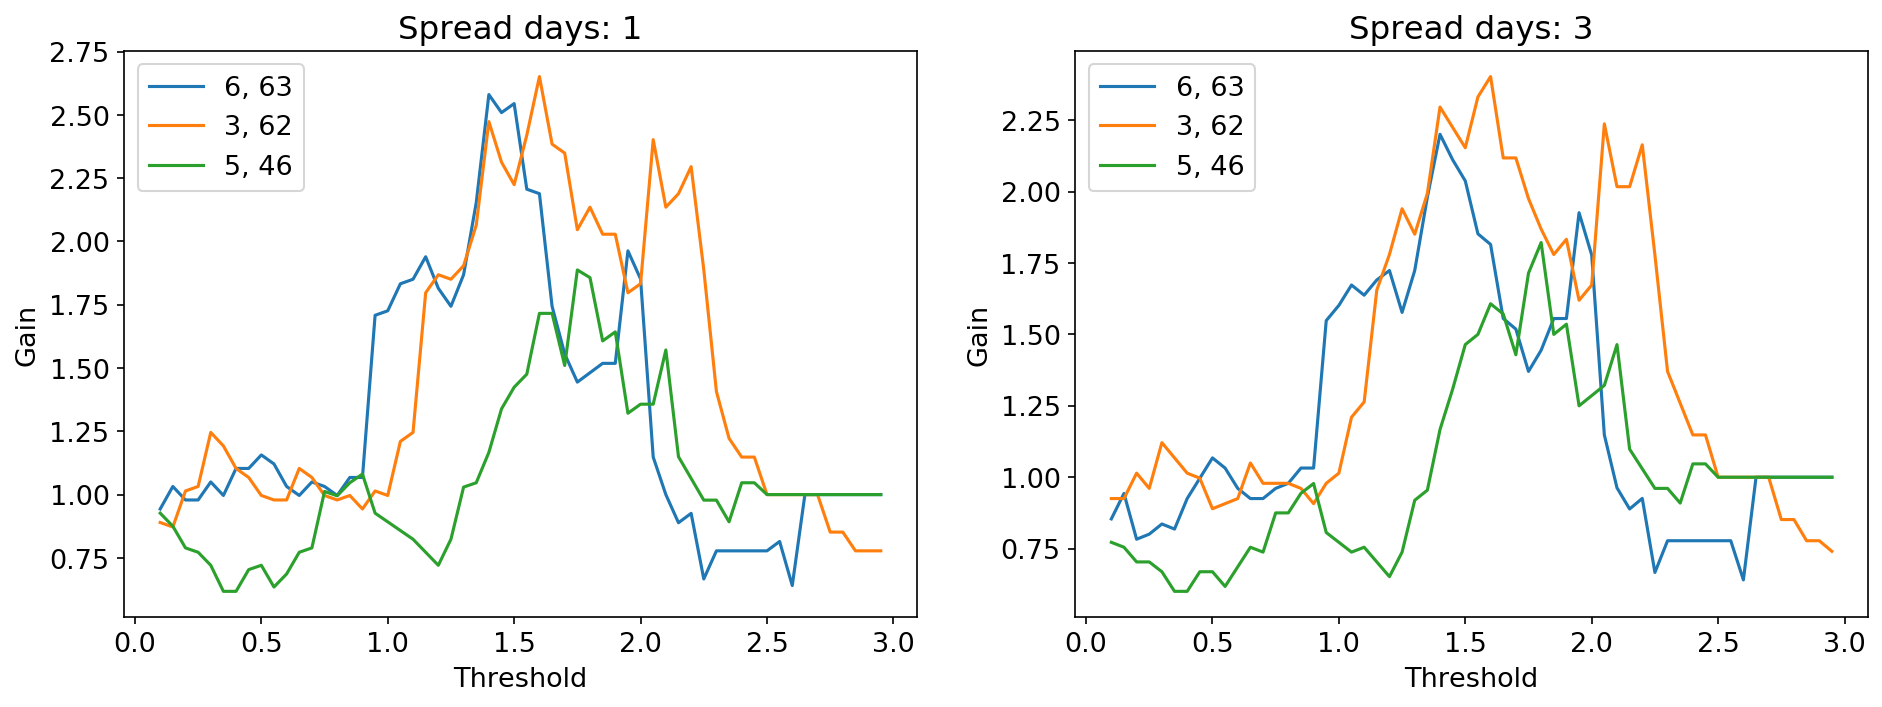

In [514]:
stock1 = 'ADBE'
stock2 = 'MSFT'

fig = plt.figure(figsize=(15,5), dpi=150)

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Spread days: 1')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Gain')
threshold_plot(stock1, stock2, 6, 63, 1)
threshold_plot(stock1, stock2, 3, 62, 1)
threshold_plot(stock1, stock2, 5, 46, 1)

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Spread days: 3')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Gain')
threshold_plot(stock1, stock2, 6, 63, 3)
threshold_plot(stock1, stock2, 3, 62, 3)
threshold_plot(stock1, stock2, 5, 46, 3)

Based on the curves of these three points we can make the weak inference that the optimal threshold is about 1.5 for most combinations of long and short window, at least for the ones in the high-gain region, such as those with the blue and orange curves. In addition, nowhere do the curves with spread days of 3 exceed those with spread days 1, so we can dispense with any remaining notion that the spread days of 1 would not be supreme.

It is also worth noting that the optimum point, represented by the blue curve, is after all not the overall optimum, since the orange curve exceeds it. This is why the effect of changing parameters should not be analyzed individually, but rather grid search, or some more efficient optimization method, should be used throughout the parameter space.

# Bagging

The point of the above models is to show the theoretical power of pair trading. But for practice, it is futile to base a model on so many years of data, since the character of the time series could well change during that time, so that what would have been effective for this period may be less so for future ones. Therefore some regularization should be added into the method, so that, even though the bias would increase (i.e., the profit for any given period would decrease), the model would not be overfit into any given period.

The following model is a sort of bag of models, each of which is based on data from a shorter period. The periods have a constant shift between adjacent ones. If it turns out that the optimum points for the models have small variance, their points' mean or mode would be an excellent choice of parameters to use in practice. 

The script unfortunately takes a long time. As such, I have restricted the range of the *long windows* and the *thresholds* based on the above graphs, centering them on the peaks.

In [519]:
stock1 = 'ADBE'
stock2 = 'MSFT'

initial_investment = 800 # USD

param_grid = {
                'now': np.arange(1, 9, 1),
                'long': np.arange(10, 80, 1),
                'threshold': np.arange(0.8, 2.0, 0.1)
             }

In [420]:
def date_strings(fold_n):
    end_i = fold_n * training_period
    start_i = end_i + training_set_length
    end = (datetime.today() - timedelta(days=end_i)).strftime('%Y-%m-%d')
    start = (datetime.today() - timedelta(days=start_i)).strftime('%Y-%m-%d')
    return start, end

def bagged_model2(training_set_length, training_period, n_folds):
    
    global data

    ends, maxs, optimum_nows, optimum_longs, optimum_thresholds = [], [], [], [], []

    for n in range(n_folds):
        print(n)
        gc.collect()
        start, end = date_strings(n)
        S1, S2 = data.loc[start:end, stock1], data.loc[start:end, stock2]
        current_max = 0
        for now, long in list(it.product(*[param_grid['now'], param_grid['long']])):
            prepped_S1, prepped_S2, Z = prepare_data(S1, S2, now, long)
            for t in param_grid['threshold']:
                V, _, _ = model2(prepped_S1, prepped_S2, Z, initial_investment, 1, False, t)
                if V[-1]/S1[-1] > current_max:
                    optimum_now = now
                    optimum_long = long
                    optimum_threshold = t
                    current_max = V[-1]/S1[-1]

        ends.append(end)
        maxs.append(current_max)
        optimum_nows.append(optimum_now)
        optimum_longs.append(optimum_long) 
        optimum_thresholds.append(optimum_threshold)
    
    opt_plots(ends, maxs, optimum_nows, optimum_longs, optimum_thresholds)

In [417]:
def opt_plots(ends, maxs, nows, longs, thresholds):
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(23, 10)
    fig.autofmt_xdate()

    axs[0,0].plot(ends, maxs)
    axs[0,0].set_title('Max gain')
    axs[0,1].plot(ends, nows)
    axs[0,1].set_title('Optimum now window')
    axs[1,0].plot(ends, longs)
    axs[1,0].set_title('Optimum long window')
    axs[1,1].plot(ends, thresholds)
    axs[1,1].set_title('Optimum threshold')

Lets try the bagged model, with 20 folds (i.e., training sets), each training set being two years long, and separated from adjacent sets by one month.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


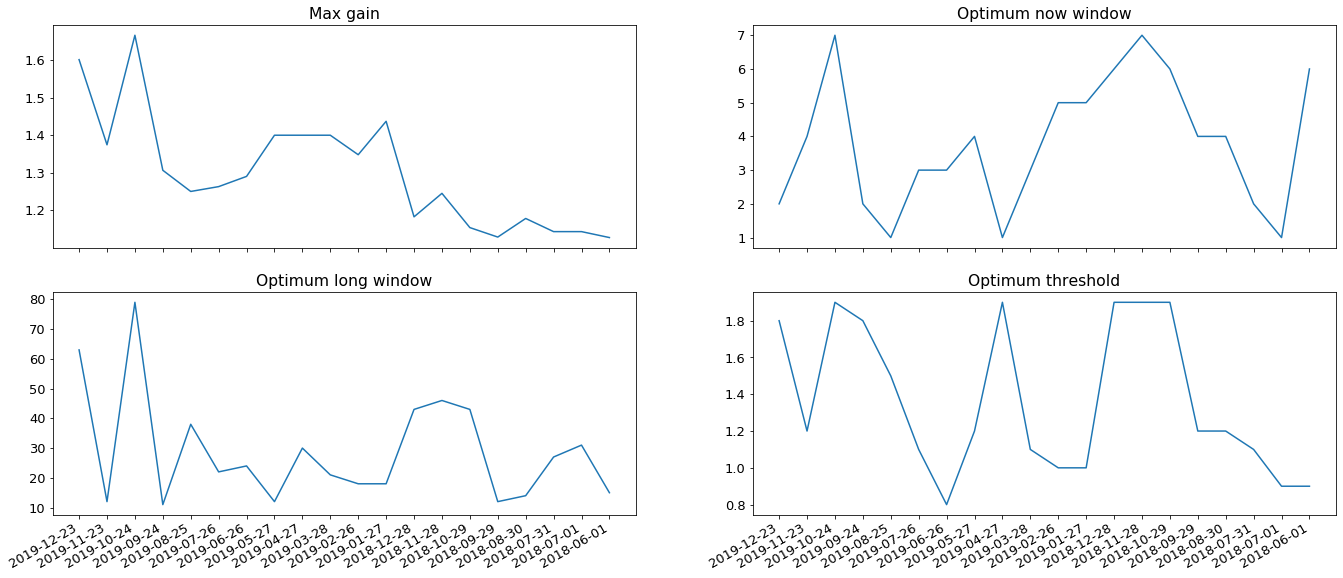

In [411]:
training_set_length = 730 # days
training_period = 30 # days
n_folds = 20

bagged_model2(training_set_length, training_period, n_folds)

These are unfortunately not at all constant. It seems that for short periods (less than three years at least) the model variance is excessively high. (And as expected, the gain is not great either.) Lets try four years instead.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


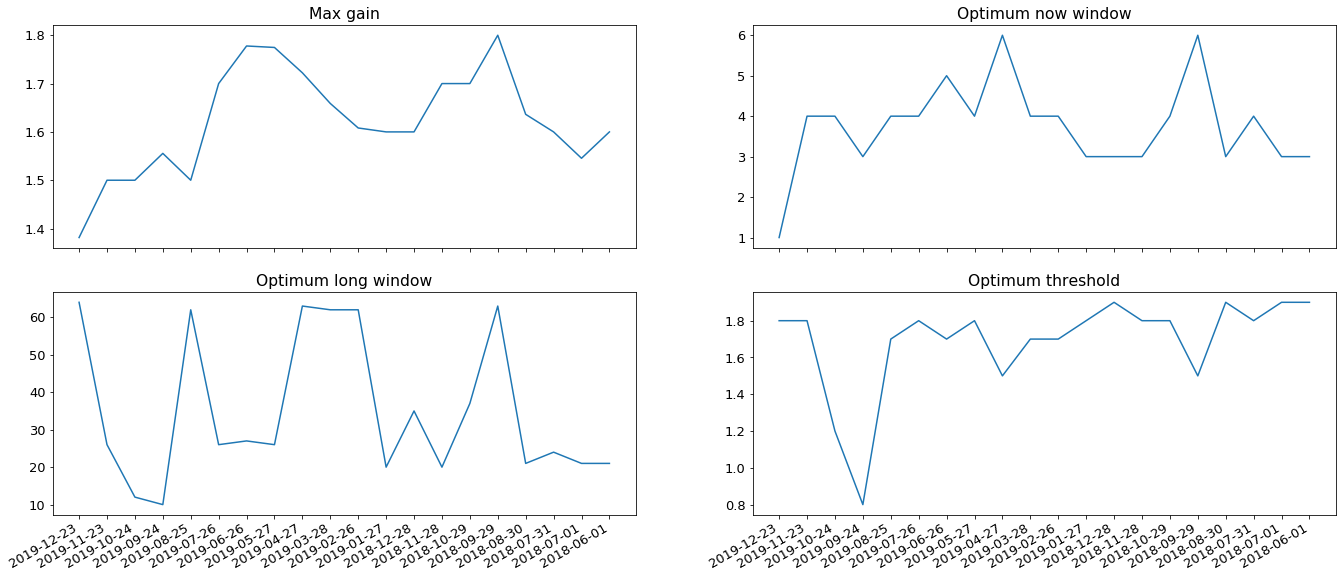

In [419]:
training_set_length = 1460 # days

bagged_model2(training_set_length, training_period, n_folds)

The variance is still too high. Given that the training sets are shifted by only a single month, the variation between the window lengths of adjacent models is obscenely high. Only the threshold has a decent variance, around 1.7. 

The gains are not bad, and would no doubt suffice for many an investor. Nevertheless, we have to conclude that as it is, the model is too unreliable for it to have excellent short-term (< 4 years at least) benefit. This model is likely to yield good gain when patiently applied for years with a mean of mode of the optimae in these graphs, but the underlying principle seems too promising to leave it in this fragile state. It is therefore time to move onto more robust approaches for predicting the triggers.

# Further ideas

Todo once I get round to it.

* Find the triggers by deep learning instead / in combination with the threshold method.
* Try buying N days after selling.
* Model adding money to the system monthly, simulating personal income.